In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target+Count Encoding: All Levels, Vary Threshold
Tune the blending midpoint, do the full NAICS hierarchy with the Target+Cont Encoder

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_count_encoder import TargetCountEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Comparison metrics

In [9]:
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('13_REPORT_metrics.csv'))

In [10]:
# Standard target encoding
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

## Function to get metrics

In [11]:
def get_metrics(data, lambda_k = 100, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetCountEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [12]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [13]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, 
                                      ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [14]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.673830,0.419480,0.310000,0.648507,0.350176,0.731164,1.0,5
1,test,0.669557,0.422275,0.309450,0.664580,0.352873,0.732585,1.0,10
1,test,0.657597,0.424623,0.305641,0.695288,0.351207,0.731773,1.0,20
1,test,0.661947,0.425327,0.307721,0.688436,0.354899,0.734760,1.0,50
1,test,0.654430,0.430338,0.307189,0.718298,0.362341,0.738229,1.0,100
1,test,0.643070,0.425883,0.300887,0.728534,0.362666,0.736182,1.0,200
1,test,0.704052,0.426819,0.329306,0.606378,0.362899,0.739270,1.0,500
1,test,0.697888,0.432142,0.328155,0.632603,0.365978,0.740882,1.0,1000
1,test,0.694952,0.430980,0.325988,0.635733,0.365368,0.740384,1.0,2000


In [15]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.660628,0.452039,0.338412,0.680539,0.387199,0.730443,0.0,5
0,test,0.660211,0.452453,0.338389,0.682516,0.387110,0.730632,0.0,10
0,test,0.658616,0.451821,0.337327,0.683972,0.387061,0.730493,0.0,20
0,test,0.659740,0.452091,0.337997,0.682464,0.386488,0.730532,0.0,50
0,test,0.661013,0.452604,0.338853,0.681319,0.387845,0.731043,0.0,100
0,test,0.661067,0.452132,0.338671,0.679915,0.386916,0.730280,0.0,200
0,test,0.658338,0.452165,0.337344,0.685481,0.385586,0.730157,0.0,500
0,test,0.654657,0.449850,0.334550,0.686417,0.382555,0.728335,0.0,1000
0,test,0.652507,0.450108,0.333660,0.691411,0.380077,0.727677,0.0,2000


In [16]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A03_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A03_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

#### Regular randomized test

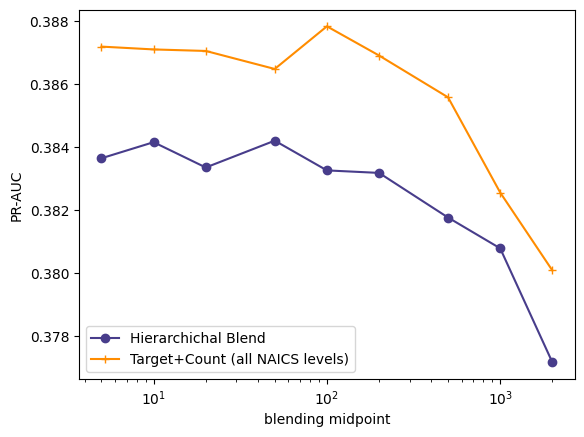

In [17]:
fig, ax = plt.subplots()
metrics_base[metrics_base['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal Blend',color='darkslateblue', style='o-')
metrics_df[metrics_df['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count (all NAICS levels)',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A03_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

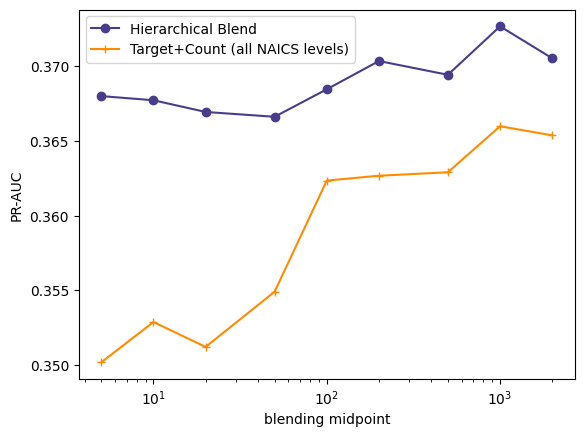

In [18]:
fig, ax = plt.subplots()
metrics_base[metrics_base['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchical Blend',color='darkslateblue', style='o-')
metrics_df[metrics_df['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count (all NAICS levels)',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A03_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

## 3-way plot with standard

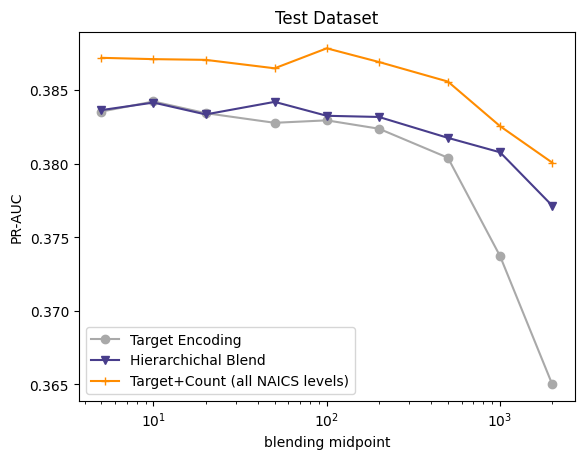

In [20]:
fig, ax = plt.subplots()
metrics_tenc[metrics_tenc['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target Encoding',color='darkgray', style='o-')
metrics_base[metrics_base['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal Blend',color='darkslateblue', style='v-')
metrics_df[metrics_df['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count (all NAICS levels)',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint')
ax.set_title('Test Dataset')
fig.savefig(Path(setup.temp_path).joinpath('A03_PLOT_compare_base_reg_all.png'),
            bbox_inches='tight')

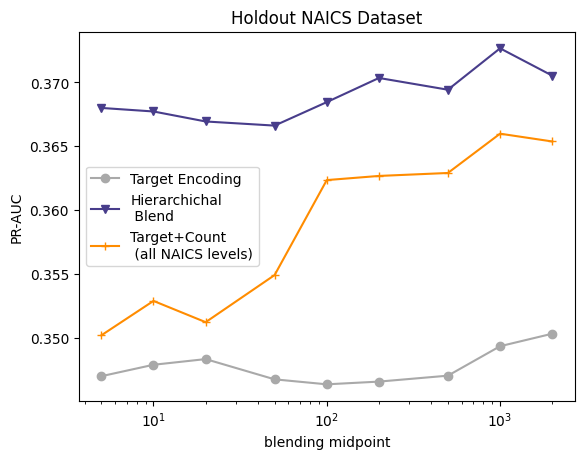

In [21]:
fig, ax = plt.subplots()
metrics_tenc[metrics_tenc['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target Encoding',color='darkgray', style='o-')
metrics_base[metrics_base['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal\n Blend',color='darkslateblue', style='v-')
metrics_df[metrics_df['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count\n (all NAICS levels)',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint')
ax.set_title('Holdout NAICS Dataset')
fig.savefig(Path(setup.temp_path).joinpath('A03_PLOT_compare_base_ho_all.png'),
            bbox_inches='tight')